In [1]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn, torch.nn.functional as F
import torch.optim as optim, torch.utils.data as data
import torchvision.datasets as datasets
import time, copy, random, os, numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split
from torchsummary import summary

In [2]:
BATCH_SIZE = 64
INPUT_SIZE = (3, 32, 32)
EPOCHS = 150
LEARNING_RATE = 1e-3


In [3]:
#Verify GPU
!nvidia-smi

Mon Apr 10 23:42:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Specify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Sets the seed for numpy and torch to make sure functions with a random component behave deterministically
# torch.backends.cudnn.deterministic = true sets the CuDNN to deterministic mode.
# This function allows us to run experiments 100% deterministically.
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

# 1.  Load and Batch the Data

In [6]:
def get_data_loaders(batch_size, root = '.data', valid_ratio = 0.1):
  
    #means and stds for the 3 channels of the dataset
    means = (0.4914, 0.4822, 0.4465)
    stds = (0.2023, 0.1994, 0.2010)

    #   Performs the following data augmentations on the training set:
    #       1.  Random Rotation:  
    #       2.  RandomHorizontalFlip
    #       3.  Random Crop
    #       4.  AutoAugment: AutoAugmention policies learned from the CIFAR10 dataset
    #           AutoAugment: Learning Augmentation Strategies from Data" <https://arxiv.org/pdf/1805.09501.pdf>`
    train_transforms = transforms.Compose([
                           #transforms.RandomRotation(5),
                           #transforms.RandomHorizontalFlip(0.5),
                           #transforms.RandomCrop(32, padding = 2),
                           #transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
                           transforms.ToTensor(),  # convert data to torch.FloatTensor: CxHxW
                           transforms.Normalize(mean = means, std = stds, inplace=True), #Range is in [-1,1], data = (data - mean)/std
                       ])

    test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, std = stds, inplace=True),
                       ])

    # choose the training and test datasets
    train_data = datasets.CIFAR10(root, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)
    
    test_data = datasets.CIFAR10(root, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)
    
    # obtain number of training/validation examples that will be used to create the respective datasets 
    n_train_examples = int((1 - valid_ratio) * len(train_data))
    n_valid_examples = int(valid_ratio* len(train_data))

    train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])
    
    #Creates a deep copy
    valid_data = copy.deepcopy(valid_data)  
    valid_data.dataset.transform = test_transforms

    # load training data in batches
    train_dataloader = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = batch_size,
                                 num_workers=2, 
                                 pin_memory=True)   #pin_memory speeds transfer of data from CPU to GPU

    # load validation data in batches
    valid_dataloader = data.DataLoader(valid_data,
                                 batch_size = batch_size,
                                 num_workers=2, 
                                 pin_memory=True)

    # load test data in batches
    test_dataloader = data.DataLoader(test_data,
                                batch_size = batch_size,
                                num_workers=2, 
                                pin_memory=True)
  
    return train_dataloader, valid_dataloader, test_dataloader

In [7]:
# Load and batch the data
train_dataloader, valid_dataloader, test_dataloader = get_data_loaders(BATCH_SIZE)

100%|██████████| 170498071/170498071 [00:12<00:00, 13124876.38it/s]


Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


# 2.  Define the Network

In [8]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

#Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=3,padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

#1. Convolutional Layer: conv1
#2. Residual Layers: layer1, layer2, layer3, layer4
#3. Fully Connected Layer: linear
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

#ResNet18 has 4 residual layers, each composed of a specifed number of residual blocks
def ResNet18():
    return ResNet(BasicBlock, [5,4,3,2])


# 3.  Specify Model, Loss Function, Optimizer, and Scheduler

In [9]:
# Specify the model, loss function, and optimizer; move model to device
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Specify scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')


In [10]:
# Check total number of parameters
summary(model, input_size=INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,432
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          18,432
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1, 64,

#4. Training and Validation

In [11]:
# accuracy is the fraction of predictions the model got correct
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# time interval for each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
def train(model, iterator, optimizer, criterion, device):
    
    # Tracks training loss and accuracy as model trains
    epoch_loss = 0
    epoch_acc = 0
    #lrs = []

    # Prep model for training
    model.train()

    for (x, y) in iterator:
        # Move inputs and labels to device
        x = x.to(device)
        y = y.to(device)
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model        
        y_pred = model(x)
        
        # Calculate the loss
        loss = criterion(y_pred, y)
        
        # Calculate the accuracy
        acc = calculate_accuracy(y_pred, y)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        #OneCycleLr Scheduler
        #scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def evaluate(model, iterator, criterion, device):
    # Keeps track of validation loss and  accuracy
    epoch_loss = 0
    epoch_acc = 0
    
    # Prep model for evaluation
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            # Forward Pass
            y_pred = model(x)
            # Calculate the validation loss
            loss = criterion(y_pred, y)
            #Calculate the validation accuracy
            acc = calculate_accuracy(y_pred, y)

            #Record validation loss
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
# Train and Validate the model:

# Tracks average training loss and accuracy per epoch
#  and tracks average validation loss and accuracy per epoch
Train_Loss = []
Train_Acc = []
Val_Loss = []
Val_Acc = []


# Tracks best validation loss
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    # Epoch start time
    start_time = time.monotonic()


    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

    # OnReducePlateau is a scheduler monitoring validation loss
    scheduler.step(valid_loss)

    # Saves model with best validation loss in a state dictionary
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'Model_4.pt')
    # Epoch end time
    end_time = time.monotonic()

    #MultistepLR
    #scheduler.step()

    # Prints training/validation statistics as well as epoch time
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} || EpochTime: {epoch_mins}m{epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} || Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val Loss: {valid_loss:.3f} ||  Val Acc: {valid_acc*100:.2f}%')

    Train_Loss.append(train_loss)
    Train_Acc.append(train_acc)
    Val_Loss.append(valid_loss)
    Val_Acc.append(valid_acc)



Epoch: 01 || EpochTime: 0m14s
	Train Loss: 1.370 || Train Acc: 49.92%
	 Val Loss: 1.114 ||  Val Acc: 59.38%
Epoch: 02 || EpochTime: 0m13s
	Train Loss: 0.864 || Train Acc: 69.45%
	 Val Loss: 0.769 ||  Val Acc: 73.00%
Epoch: 03 || EpochTime: 0m13s
	Train Loss: 0.641 || Train Acc: 77.38%
	 Val Loss: 0.688 ||  Val Acc: 76.09%
Epoch: 04 || EpochTime: 0m13s
	Train Loss: 0.511 || Train Acc: 82.34%
	 Val Loss: 0.570 ||  Val Acc: 80.78%
Epoch: 05 || EpochTime: 0m14s
	Train Loss: 0.409 || Train Acc: 85.76%
	 Val Loss: 0.571 ||  Val Acc: 80.93%
Epoch: 06 || EpochTime: 0m13s
	Train Loss: 0.321 || Train Acc: 88.74%
	 Val Loss: 0.562 ||  Val Acc: 82.00%
Epoch: 07 || EpochTime: 0m13s
	Train Loss: 0.250 || Train Acc: 91.14%
	 Val Loss: 0.617 ||  Val Acc: 81.33%
Epoch: 08 || EpochTime: 0m13s
	Train Loss: 0.193 || Train Acc: 93.32%
	 Val Loss: 0.539 ||  Val Acc: 84.63%
Epoch: 09 || EpochTime: 0m13s
	Train Loss: 0.145 || Train Acc: 94.93%
	 Val Loss: 0.603 ||  Val Acc: 83.31%
Epoch: 10 || EpochTime: 0m13

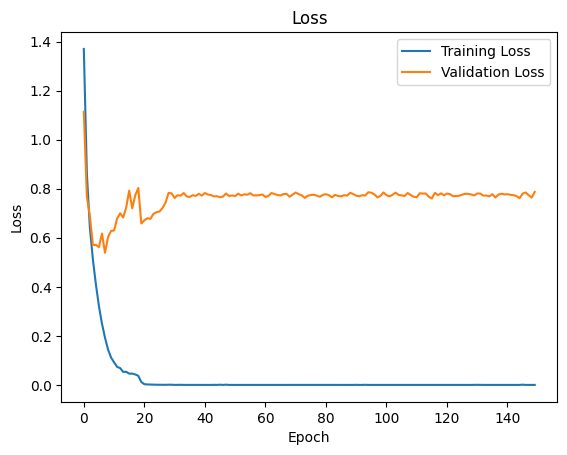

In [15]:
# visualize the loss as the network trained
def get_loss_plot(train_loss, val_loss):
    plt.plot(range(len(train_loss)),train_loss)
    plt.plot(range(len(train_loss)),val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.savefig('Model_4.png')
    plt.show()
    
    
# Prints training loss and validation loss 
get_loss_plot(Train_Loss, Val_Loss)

#5.  Evaluate Best Saved Model on Test Dataset

In [16]:
# Load saved model's parameters
model.load_state_dict(torch.load('Model_4.pt'))

# Calculate test loss and accuracy
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)


print(f'Test Loss: {test_loss:.3f} || Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.535 || Test Acc: 84.02%
